In [1]:
import descarteslabs as dl
import matplotlib.pyplot as plt
import geopandas as gpd

from math import cos
from collections import defaultdict

## Iowa active animal feeding operations dataset

#### Load in the Iowa active sites dataset

In [2]:
active_sites_df = gpd.read_file('../datasets/derived_data/iowa_active_sites.geojson')
active_sites_df

,facName,LocAddress,CityName,State,locZip,OperatType,Swine,CattleDairy,CattleBeef,Chickens,...,BeefCattle Present,Chickens Present,Turkeys Present,Horses Present,Sheep/Goats Present,Animals Present,colMthTxt,refPntTxt,ColDate,geometry
0,Guthrie Center Egg Farm - Laop,2143 215TH ROAD,Guthrie Center,IA,50115-8542,Confinement,NaN,NaN,NaN,13893.0,...,False,True,False,False,False,Chickens,INTERPOLATION-PHOTO,PLANT ENTRANCE (GENERAL),2011-07-27,POINT (-94.52205 41.69573)
1,"Sunrise Farms, Inc",2060 WHITE AVE,Harris,IA,51345,Confinement,NaN,NaN,NaN,80000.0,...,False,True,False,False,False,Chickens,INTERPOLATION-PHOTO,PLANT ENTRANCE (GENERAL),2017-05-18,POINT (-95.44726 43.34870)
2,Daybreak Foods Vincent Complex,3159 BUCHANAN AVE,Eagle Grove,IA,50533,Confinement,NaN,NaN,NaN,60383.0,...,False,True,False,False,False,Chickens,INTERPOLATION-PHOTO,PLANT ENTRANCE (GENERAL),2005-09-06,POINT (-93.94223 42.59563)
3,"Cedar Lane Estates, Incorporated",1114 J AVE,Jefferson,IA,50129,Confinement,1992.0,NaN,NaN,NaN,...,False,False,False,False,False,Swine,INTERPOLATION-PHOTO,PLANT ENTRANCE (GENERAL),2017-01-04,POINT (-94.46129 42.06094)
4,Jbh Groeneweg Site 1,2864 Fig Ave,Rock Valley,IA,51247,Open Feedlot,NaN,NaN,700.0,NaN,...,True,False,False,False,False,BeefCattle,INTERPOLATION-PHOTO,CENTER OF FACILITY,2017-06-15,POINT (-96.27392 43.23656)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,Weis Family Feeders,1479 Quauk Avenue,Afton,IA,50830,Confinement,980.0,NaN,NaN,NaN,...,False,False,False,False,False,Swine,INTERPOLATION-PHOTO,CENTER OF FACILITY,2020-07-16,POINT (-94.16158 41.08844)
9979,Thompson Pork - Jake & Danielle Thompson,250th Street,Bridgewater,IA,508370000,Confinement,980.0,NaN,NaN,NaN,...,False,False,False,False,False,Swine,INTERPOLATION-PHOTO,CENTER OF FACILITY,2020-07-16,POINT (-94.63784 41.29117)
9980,Brush Creek Henhouse Llc,175th Street,Leon,IA,50144,Confinement,NaN,NaN,NaN,200.0,...,False,True,False,False,False,Chickens,INTERPOLATION-PHOTO,CENTER OF FACILITY,2020-07-30,POINT (-93.73882 40.79384)
9981,Kaufman Farms Llc,Cedar Road,Panama,IA,51562,Confinement,980.0,NaN,NaN,NaN,...,False,False,False,False,False,Swine,INTERPOLATION-PHOTO,CENTER OF FACILITY,2020-07-29,POINT (-95.31149 41.69327)


#### Number of sites with each reference point type

In [3]:
active_sites_df['refPntTxt'].value_counts()

CENTER OF FACILITY                       3591
PLANT ENTRANCE (GENERAL)                  330
STORAGE TANK                                6
ADMINISTRATIVE BUILDING                     2
COMBINED ANIMAL FEED OPERATION (CAFO)       1
Name: refPntTxt, dtype: int64

#### Number of sites with no reference point type listed

In [4]:
sum(active_sites_df['refPntTxt'].isnull())

6053

## Helper Functions

In [ ]:
def fetch_full_coverage_scenes(bbox_lat, bbox_long, bbox_res, bbox_length, image_collection, start_date, end_date):
    """
    Searches for imagery in an image collection over a date range that completely covers the defined
    bounding box
    
    Arguments:
    bbox_lat:         latitude of the bounding box center (float)
    bbox_long:        longitude of the bounding box center (float)
    bbox_res:         pixel resolution in meters (float)
    bbox_length:      desired length of the bounding box in pixels (int)
    image_collection: image collection descriptor (string)
    start_date:       start of date range (string, format 'YYYY-MM-DD')       
    end_date:         end of date range (string, format 'YYYY-MM-DD')
    
    Returns a list of scenes providing full coverage of the bounding box. If bbox_length is an even
    number, the resulting scenes will have a length of bbox_length-1 pixels due to the nature of
    the tile definition.
    """
    # Define the bounding box
    # In order for the tile to be centered on the (lat,long) location, we need to specify the tile 
    # size as a single pixel and add additional padding. Therefore the tile length will always be an
    # odd number.
    tile_size = 1
    tile = dl.scenes.DLTile.from_latlon(bbox_lat, bbox_long, resolution, tile_size, int(bbox_length/2))
    
    # Fetch the scenes that overlap with the bounding box
    scenes, ctx = dl.scenes.search(aoi=tile, products=[image_collection], start_datetime=start_date, 
                                   end_datetime=end_date)
    
    # Filter down to the scenes that provide full coverage
    full_scenes = [s for s in scenes if (1-s.coverage(tile)) <= 1e-6]
    
    return full_scenes

## NAIP Imagery

### Timeframe coverage

#### NAIP 1 meter collection timeframe

In [5]:
naip_1m_start = '2012-01-01'
naip_1m_end = '2018-01-01'

#### Identify which sites were labeled prior to the end of the NAIP 1 meter collection

In [6]:
naip_1m_idx = []
for i in range(len(active_sites_df)):
    if active_sites_df.iloc[i].ColDate <= naip_1m_end:
        naip_1m_idx.append(i)

In [7]:
len(naip_1m_idx)

9491

#### NAIP 0.6 meter collection timeframe

In [8]:
naip_06m_start = '2018-01-01'
naip_06m_end = '2018-12-31'

#### Identify which sites were labeled prior to the end of the NAIP 0.6 meter collection

In [9]:
naip_06m_idx = []
for i in range(len(active_sites_df)):
    if active_sites_df.iloc[i].ColDate <= naip_06m_end:
        naip_06m_idx.append(i)

In [10]:
len(naip_06m_idx)

9820

### Annotation offset

#### Example of site location placed at the center of the facility

In [11]:
center_facility_df = active_sites_df[active_sites_df['refPntTxt'] == 'CENTER OF FACILITY']

In [12]:
g = center_facility_df.iloc[0].geometry.coords
site_long = g.xy[0][0]
site_lat = g.xy[1][0]

In [13]:
tile = dl.scenes.DLTile.from_latlon(site_lat, site_long, 1, 1, 500)
scenes, ctx = dl.scenes.search(
    aoi=tile,
    products=["usda:naip:rgbn:v1"],
    start_datetime=naip_1m_start,
    end_datetime=naip_1m_end
)

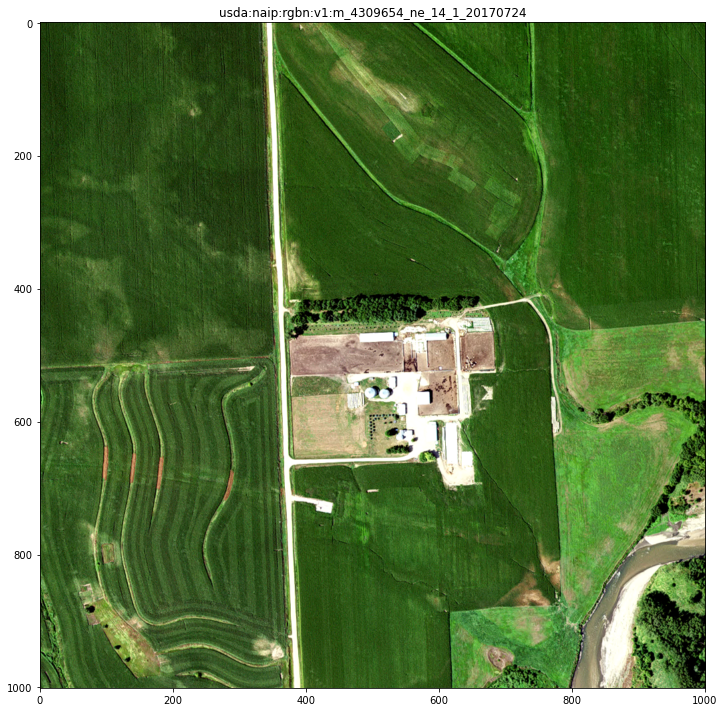

In [14]:
scene = scenes[0]                                  
arr = scene.ndarray("red green blue", ctx)
dl.scenes.display(arr, title=scene.properties.id)

#### Example of site location placed at the plant entrance

In [15]:
plant_entrance_df = active_sites_df[active_sites_df['refPntTxt'] == 'PLANT ENTRANCE (GENERAL)']

In [16]:
g = plant_entrance_df.iloc[0].geometry.coords
site_long = g.xy[0][0]
site_lat = g.xy[1][0]

In [17]:
tile = dl.scenes.DLTile.from_latlon(site_lat, site_long, 1, 1, 500)
scenes, ctx = dl.scenes.search(
    aoi=tile,
    products=["usda:naip:rgbn:v1"],
    start_datetime=naip_1m_start,
    end_datetime=naip_1m_end
)

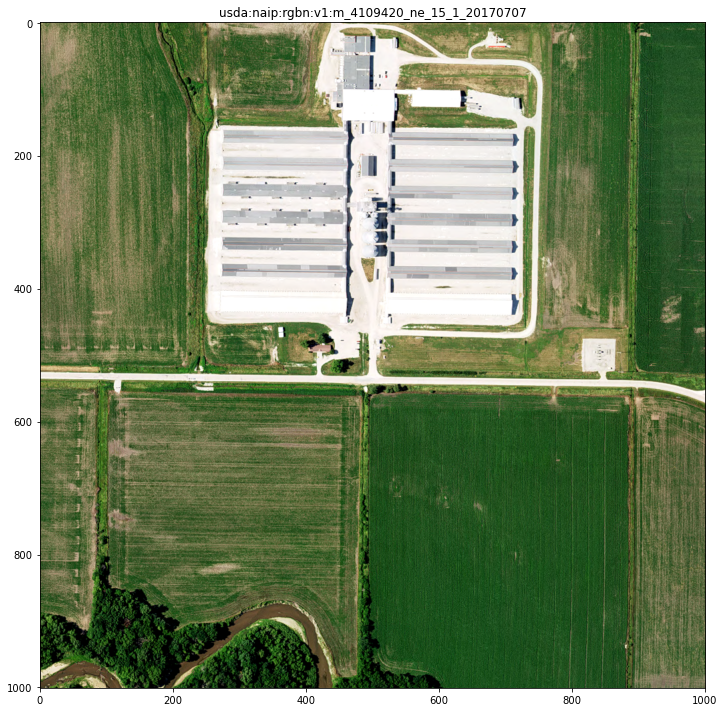

In [18]:
scene = scenes[0]                                  
arr = scene.ndarray("red green blue", ctx)
dl.scenes.display(arr, title=scene.properties.id)

### Identify the scenes completely covering a 1 kilometer bounding box centered on the site coordinates

#### NAIP 1 meter collection

In [19]:
naip_1m_site_scenes = defaultdict(list)
j = 0
for i in naip_1m_idx:
    
    # Get the site record
    site = active_sites_df.iloc[i]
    
    # Get the site coordinates
    (site_long,site_lat) = site.geometry.coords[0]

    # Generate a 1 kilometer tile with 1 meter resolution per pixel
    tile = dl.scenes.DLTile.from_latlon(site_lat, site_long, 1, 1, 500)

    # Search for imagery covering the site bounding box
    scenes, ctx = dl.scenes.search(
        aoi=tile,
        products=["usda:naip:rgbn:v1"],
        start_datetime=naip_1m_start,
        end_datetime=naip_1m_end
    )
    
    # Save the scenes where the bounding box is completely covered
    for scene in scenes:
        if 1.0 - scene.coverage(tile) <= 1e-6:
            naip_1m_site_scenes[i].append(scene)
    
    break
    j += 1
    if j % 1000 == 0:
        print(f"Processed {j} sites.")

#### NAIP 0.6 meter collection